In [127]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns

In [114]:
data = pd.concat(load_iris(return_X_y=True, as_frame=True), axis='columns')
data.sample(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
100,6.3,3.3,6.0,2.5,2
116,6.5,3.0,5.5,1.8,2
103,6.3,2.9,5.6,1.8,2
70,5.9,3.2,4.8,1.8,1
133,6.3,2.8,5.1,1.5,2


In [115]:
data.corr()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
sepal length (cm),1.000000,-0.117570,0.871754,0.817941,0.782561
sepal width (cm),-0.117570,1.000000,-0.428440,-0.366126,-0.426658
petal length (cm),0.871754,-0.428440,1.000000,0.962865,0.949035
petal width (cm),0.817941,-0.366126,0.962865,1.000000,0.956547
target,0.782561,-0.426658,0.949035,0.956547,1.000000


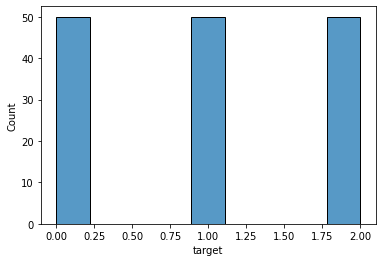

In [116]:
sns.histplot(data.target);

In [117]:
X = data.iloc[:, :-1]
y = data.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, shuffle=True)

In [118]:
param_grid = {
    'n_estimators' : np.arange(200, 1000, 100),
    'criterion' : ['gini', 'entropy', 'log_loss'],
    'min_samples_leaf' : [2, 3]
}
grid_model = GridSearchCV(RandomForestClassifier(), param_grid=param_grid)
grid_model.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'min_samples_leaf': [2, 3],
                         'n_estimators': array([200, 300, 400, 500, 600, 700, 800, 900])})

In [119]:
grid_model.best_params_

{'criterion': 'gini', 'min_samples_leaf': 2, 'n_estimators': 200}

In [120]:
accuracy_score(y_test, grid_model.predict(X_test))

0.9210526315789473

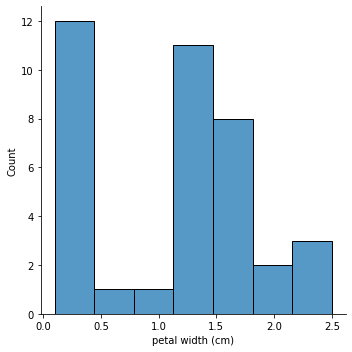

In [121]:
sns.displot(X_test['petal width (cm)']);

As we see from correlation matrix the correlation coefficient between $target$ and $petal width (cm)$ columns is high. Based on this information I will create model with prediction as rounding $petal width (cm)$ column values:

In [122]:
def my_simple_model(data : pd.Series) -> pd.Series:
    '''
    My experimental function
    '''
    res = np.around(data).astype(int)
    return res

In [125]:
f"Test accuracy with RandomForestClassifier - {accuracy_score(y_test, grid_model.predict(X_test))}"

'Test accuracy with RandomForestClassifier - 0.9210526315789473'

In [126]:
f"Test accuracy on my simple model - {accuracy_score(y_test, my_simple_model(X_test['petal width (cm)']))}"

'Test accuracy on my simple model - 0.8947368421052632'

In [134]:
svc_grid = {
    'C' : np.arange(1, 3, .5),
    'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree' : np.arange(1, 6, 1),
    'gamma' : ['scale', 'auto']
}
svc_model = GridSearchCV(SVC(), param_grid=svc_grid)
svc_model.fit(X_train, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': array([1. , 1.5, 2. , 2.5]),
                         'degree': array([1, 2, 3, 4, 5]),
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']})

In [135]:
svc_model.best_params_

{'C': 2.0, 'degree': 1, 'gamma': 'auto', 'kernel': 'poly'}

In [136]:
f"SVM model accuracy = {accuracy_score(y_test, svc_model.predict(X_test))}"

'SVM model accuracy = 0.9736842105263158'